In [1]:
# IR Components
# 1. Crawler + Indexer -> Crawler / Indexer
# 2. Doc Analyzer -> (Improved) BoW
# 3. Query -> 2번과 동일 -> DTM(TDM)
# 4. Ranking Model

In [1]:
# 1-1. (Focused) Crawler (BFS) - 네이버 뉴스
from requests import get
from requests.compat import urljoin
from bs4 import BeautifulSoup
import re

urls = ['https://news.naver.com']
visited = list()

path = './naver/'

while urls:
    seed = urls.pop(0) # Queue
    visited.append(seed)
    
    dom = BeautifulSoup(get(seed).text, 'html.parser')
    body = dom.select_one('#articleBodyContents')
    
    if body: # 뉴스
        cid = re.search('rankingSectionId=(\d+)', seed).group(1)
        aid = re.search('aid=(\d+)', seed).group(1)
        
        file = '{0}-{1}.txt'.format(cid, aid)
        with open(path+file, 'w', encoding='utf-8') as f:
            f.write(body.text)
    else: # 링크
        for a in dom.select('div[id^=ranking_] li > a'):
            link = urljoin(seed, a['href'])
            if link not in urls and link not in visited:
                urls.append(link)

In [2]:
from string import punctuation
pattern1 = re.compile(r'[{}]'.format(re.escape(punctuation)))
pattern2 = re.compile(r'\b(\w|[.])+@(?:[.]?\w+)+\b')
pattern3 = re.compile(r'\bhttps?://\w+(?:[.]?\w+)+\b')
pattern4 = re.compile(r'[^A-Za-z0-9가-힣ㄱ-ㅎㅏ-ㅣ ]')
pattern5 = re.compile(r'\b[a-z][A-Za-z0-9]+\b')
pattern6 = re.compile(r'\s{2,}')

In [3]:
# 1-2. Indexer
from os import listdir
from konlpy.tag import Okt

okt = Okt()

def fileids(path = './naver/'):
    return [path+_ for _ in listdir(path)
            if re.search('[.]txt$', _)]

def cleaning(doc):
    return pattern6.sub(' ',
           pattern1.sub(' ',
           pattern5.sub(' ',
           pattern4.sub(' ',
           pattern2.sub(' ', doc))))).strip()

def tokenizer1(doc): # 어절
    return doc.split()

def tokenizer2(tokens, n=2): # 어절 Ngram
    ngram = list()
    for i in range(len(tokens) - (n-1)):
        ngram.append(i)
    return ngram

def tokenizer3(doc, n=2): # 음절 Ngram
    ngram = list()
    for i in range(len(doc) - (n-1)):
        ngram.append(doc[i:i+n])
    return ngram

def tokenizer4(doc): # 형태소
    return [_ for _ in okt.morphs(doc) if 1 < len(_) < 8]

def tokenizer5(doc): # 명사
    return [_ for _ in okt.nouns(doc) if 1 < len(_) < 8]

In [4]:
from collections import defaultdict
def get_tokens(file):
    print(file)
    terms = defaultdict(lambda:0)
    
    with open(file, 'rt', encoding = "utf-8") as f:
        news = cleaning(f.read())

    for _ in tokenizer1(news):
        terms[_] += 1
    for _ in tokenizer2(list(terms.keys())):
        terms[_] += 1
    for _ in tokenizer3(news):
        terms[_] += 1
    for _ in tokenizer4(news):
        terms[_] += 1
        
    return terms

def indexer(filelist):
    tokens = defaultdict(list)
    posting = list()
    
    for i, file in enumerate(filelist):
        for k, v in get_tokens(file).items():
            if k in tokens:
                info = (k, i, v, tokens[k])
                posting.append(info)
                tokens[k] = posting.index(info)
            else:
                info = (k, i, v, -1)
                posting.append(info)
                tokens[k] = posting.index(info)
                
    return tokens, posting

In [5]:
voca, posting = indexer(fileids())

./naver/100-0000304656.txt
./naver/100-0000525518.txt
./naver/100-0000525614.txt
./naver/100-0000893811.txt
./naver/100-0001478038.txt
./naver/100-0003026100.txt
./naver/100-0003026106.txt
./naver/100-0003026108.txt
./naver/100-0003026123.txt
./naver/100-0003026140.txt
./naver/100-0003026143.txt
./naver/100-0003026185.txt
./naver/100-0003026204.txt
./naver/100-0003026206.txt
./naver/100-0003026217.txt
./naver/100-0003115712.txt
./naver/100-0003303453.txt
./naver/100-0003553848.txt
./naver/100-0003553871.txt
./naver/100-0003553912.txt
./naver/100-0003783276.txt
./naver/100-0004635432.txt
./naver/100-0004635535.txt
./naver/100-0004635770.txt
./naver/100-0004713895.txt
./naver/100-0004814256.txt
./naver/100-0011815182.txt
./naver/100-0011815189.txt
./naver/100-0011815196.txt
./naver/100-0011815383.txt
./naver/100-0011815743.txt
./naver/101-0000245180.txt
./naver/101-0000525539.txt
./naver/101-0000834792.txt
./naver/101-0000893812.txt
./naver/101-0001351992.txt
./naver/101-0001352063.txt
.

In [6]:
query = '대형 초밥 체인점 한국어 메뉴에만 냉수 180엔 부과재일 교포 A씨 트위터에 해당 사건 공유해 일파만파'
qterms = tokenizer1(query)
qterms += tokenizer2(qterms)
qterms += tokenizer3(query)
qterms += tokenizer4(query)
qterms += tokenizer5(query)

In [7]:
result = list()
for t in qterms:
    temp = list()
    if t in voca:
        print(t)
        pos = voca[t]
        while pos > -1:
            info = posting[pos]
            pos = info[-1]
            temp.append(str(info[1]))
            result.append(info[1])
    print(','.join(temp))
    print()

대형
148,128,122,119,102,92,84,55,41,31



체인점
81,75













A씨
69,59,58,47

트위터에
152,147,131,130,123,114

해당
146,135,120,105,102,100,96,93,91,84,64,58,56,49,37,35,33,23,21,12,9,4,2

사건
127,122,119,117,98,93,70,66,62,61,59,27,26,17,13,10





0
155,154,153,152,151,150,149,148,147,146,145,144,143,142,141,140,139,138,137,136,135,134,133,132,131,130,129,128,127,126,125,124,123,122,121,120,119,118,117,116,115,114,113,112,111,110,109,108,107,106,105,104,103,102,101,100,99,98,97,96,95,94,93,92,91,90,89,88,87,86,85,84,83,82,81,80,79,78,77,76,75,74,73,72,71,70,69,68,67,66,65,64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0

1
155,154,153,152,151,150,149,148,147,146,145,144,143,142,141,140,139,138,137,136,135,134,133,132,131,130,129,128,127,126,125,124,123,122,121,120,119,118,117,116,115,114,113,112,111,110,109,108,107,106,105,104,103,102,101,100,99,98,97,96

In [8]:
list(set(result))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155]

In [9]:
# 1-1. (Focused) Crawler (BFS) - 네이버 뉴스
from requests import get
from requests.compat import urljoin
from bs4 import BeautifulSoup

urls = ['https://news.naver.com']
visited = list()

path = './naver/'

while urls:
    seed = urls.pop(0) # Queue
    visited.append(seed)
    
    dom = BeautifulSoup(get(seed).text, 'html.parser')
    body = dom.select_one('#articleBodyContents')
    
    if body: # 뉴스
        cid = re.search('rankingSectionId=(\d+)', seed).group(1)
        aid = re.search('aid=(\d+)', seed).group(1)
        
        file = '{0}-{1}.txt'.format(cid, aid)
        with open(path+file, 'w', encoding='utf-8') as f:
            f.write(body.text)
    else: # 링크
        for a in dom.select('div[id^=ranking_] li > a'):
            link = urljoin(seed, a['href'])
            if link not in urls and link not in visited:
                urls.append(link)

In [10]:
import re
from string import punctuation
pattern1 = re.compile(r'[{}]'.format(re.escape(punctuation)))
pattern2 = re.compile(r'\b(\w|[.])+@(?:[.]?\w+)+\b')
pattern3 = re.compile(r'\bhttps?://\w+(?:[.]?\w+)+\b')
pattern4 = re.compile(r'[^A-Za-z0-9가-힣ㄱ-ㅎㅏ-ㅣ ]')
pattern5 = re.compile(r'\b[a-z][A-Za-z0-9]+\b')
pattern6 = re.compile(r'\s{2,}')

In [11]:
# 1-2. Indexer
from os import listdir
from konlpy.tag import Okt

okt = Okt()

def fileids(path = './naver/'):
    return [path+_ for _ in listdir(path)
            if re.search('[.]txt$', _)]

def cleaning(doc):
    return pattern6.sub(' ',
           pattern1.sub(' ',
           pattern5.sub(' ',
           pattern4.sub(' ',
           pattern2.sub(' ', doc))))).strip()

def tokenizer1(doc): # 어절
    return doc.split()

def tokenizer2(tokens, n=2): # 어절 Ngram
    ngram = list()
    for i in range(len(tokens) - (n-1)):
        ngram.append(i)
    return ngram

def tokenizer3(doc, n=2): # 음절 Ngram
    ngram = list()
    for i in range(len(doc) - (n-1)):
        ngram.append(doc[i:i+n])
    return ngram

def tokenizer4(doc): # 형태소
    return [_ for _ in okt.morphs(doc) if 1 < len(_) < 8]

def tokenizer5(doc): # 명사
    return [_ for _ in okt.nouns(doc) if 1 < len(_) < 8]

In [12]:
import struct
from struct import pack, unpack

In [38]:
def get_tokens(file):
    terms = defaultdict(lambda:0)
    
    with open(file, 'rt', encoding = 'utf-8') as f:
        news = cleaning(f.read())

    for _ in tokenizer1(news):
        terms[_] += 1
    for _ in tokenizer2(list(terms.keys())):
        terms[_] += 1
    for _ in tokenizer3(news):
        terms[_] += 1
    for _ in tokenizer4(news):
        terms[_] += 1
        
    return terms

def indexer(file):
    lexicon = dict()
    
    for k, v in get_tokens(file).items():
        if k not in lexicon:
            lexicon[k] = 1
        else:
            lexicon[k] += 1
                
    return lexicon

def mergeLexicon(Lexicon, i, LocalLexicon, posting):
    with open(posting, 'ab') as f:
        for k, v in LocalLexicon.items():
            termInfo = (i, v, Lexicon[k] if k in Lexicon.keys() else -1)
            Lexicon[k] = f.tell()
            f.write(pack('iii', termInfo[0], termInfo[1], termInfo[2]))
#             f.write(','.join([str(_) for _ in termInfo])+'\n')
            
    return Lexicon

def sortedLexicon(Lexicon, posting, sposting):
    sortedIndex = list()
    
    f1 = open(posting, 'r', encoding='UTF-8')
    f2 = open(sposting, 'w', encoding='utf-8')
    
    for k, v in Lexicon.items():
        pos1 = v
        pos2 = f2.tell()
        df = 0
        
        while pos1 > -1:
            f1.seek(pos1)
            termInfo = [int(_) for _ in f1.readline().split(',')]
            f2.write(','.join([str(_) for _ in termInfo[:2]])+'\n')
            df += 1
            pos1 = termInfo[-1]
            
        Lexicon[k] = (df, pos2)
        
    f1.close()
    f2.close()
        
    return Lexicon
            
# Liked List(동적 리스트)
# termInfo = (문서번호, 다음위치)
# Lexicon[k] -> (위치)(문서번호, 다음위치) -> (위치)(문서번호, 다음위치:-1)

# [37:39]
# Lexicon : 'ABC' -> ? (line:36)
#                    0 (line:39)

#                    (i, -1) (line:37)
# invertedIndex : 0:(i, -1) (line:38)
# [32:35]
#                    (i, Lexicon['ABC']:0) (line:33)
# invertedIndex : 0:(i, -1)
#                 1:(i,  0) (line:34)
# Lexicon : 'ABC' -> 1 (line:35)

# Lexicon, invertedIndex, sortedIndex
# Lexicon[k]                  invertedIndex           sortedIndex
# "ABC" -> 190031           190031:(60, 50)               60
#                               50:(2, -1)                 2
#       -> (2, 0)
#          df, pos [0:df+1]
#                   60, 2

In [39]:
Collection = fileids()
Lexicon = dict()
# invertedIndex = list()
posting = 'posting.dat'

for i, doc in enumerate(Collection): # 전체 문서집합
    localLexicon = indexer(doc) # 문서 당 처리 -> 단어:빈도
    Lexicon = mergeLexicon(Lexicon, i, localLexicon, posting) # 문서 합치고(역색인구조)

# Lexicon, invertedIndex = sortedLexicon(Lexicon, invertedIndex)

In [40]:
Collection = fileids()
Lexicon = dict()
# invertedIndex = list()
posting = 'posting.dat'
sposting = 'sposting.dat'
Lexicon = sortedLexicon(Lexicon, posting, sposting)

In [41]:
# Local -> Global Merge (Sorting X) : Linked List Posting Structure
with open(posting, 'rb') as f:
    for k in list(Lexicon.keys())[:10]:
        pos = Lexicon[k]
        while pos > -1:
            f.seek(pos)
            termInfo = unpack('iii', f.read(4*3))
            pos = termInfo[-1]
            print(termInfo)

In [42]:
result = list()
with open(posting, 'r', encoding = 'utf-8') as f:
    for t in qterms:
        print(t)
        if t in Lexicon.keys():
            pos = Lexicon[k]
            while pos > -1:
                f.seek(pos)
                termInfo = [int(_) for _ in f.readline().split(',')]
                pos = termInfo[-1]
                result.append(termInfo[0])
        print()
print(list(set(result)))

대형

초밥

체인점

한국어

메뉴에만

냉수

180엔

부과재일

교포

A씨

트위터에

해당

사건

공유해

일파만파

0

1

2

3

4

5

6

7

8

9

10

11

12

13

대형

형 

 초

초밥

밥 

 체

체인

인점

점 

 한

한국

국어

어 

 메

메뉴

뉴에

에만

만 

 냉

냉수

수 

 1

18

80

0엔

엔 

 부

부과

과재

재일

일 

 교

교포

포 

 A

A씨

씨 

 트

트위

위터

터에

에 

 해

해당

당 

 사

사건

건 

 공

공유

유해

해 

 일

일파

파만

만파

대형

초밥

체인점

한국어

메뉴

에만

냉수

180엔

부과

재일

교포

트위터

해당

사건

공유

일파

대형

초밥

체인점

한국어

메뉴

냉수

부과

재일

교포

트위터

해당

사건

공유

일파

[]


In [43]:
# Local -> Global Merge (Sorting X) : Linked List Posting Structure
result = list()

with open(sposting, 'rt', encoding = 'utf-8') as f:
    for t in qterms:
        print(t)
        if t in Lexicon.keys():
            termInfo = Lexicon[k]
            f.seek(termInfo[-1])
            for _ in range(termInfo[0]): # df
                termInfo = [int(_) for _ in f.readline().split(',')]
                print(termInfo)
                result.append(termInfo[0])
                
print(list(set(result)))

대형
초밥
체인점
한국어
메뉴에만
냉수
180엔
부과재일
교포
A씨
트위터에
해당
사건
공유해
일파만파
0
1
2
3
4
5
6
7
8
9
10
11
12
13
대형
형 
 초
초밥
밥 
 체
체인
인점
점 
 한
한국
국어
어 
 메
메뉴
뉴에
에만
만 
 냉
냉수
수 
 1
18
80
0엔
엔 
 부
부과
과재
재일
일 
 교
교포
포 
 A
A씨
씨 
 트
트위
위터
터에
에 
 해
해당
당 
 사
사건
건 
 공
공유
유해
해 
 일
일파
파만
만파
대형
초밥
체인점
한국어
메뉴
에만
냉수
180엔
부과
재일
교포
트위터
해당
사건
공유
일파
대형
초밥
체인점
한국어
메뉴
냉수
부과
재일
교포
트위터
해당
사건
공유
일파
[]


In [44]:
result = list()
for t in qterms:
    print(t)
    if t in Lexicon.keys():
        result += invertedIndex[Lexicon[t][1]:sum(Lexicon[t])]
        print(invertedIndex[Lexicon[t][1]:sum(Lexicon[t])])
    print()
print(list(set(result)))

대형

초밥

체인점

한국어

메뉴에만

냉수

180엔

부과재일

교포

A씨

트위터에

해당

사건

공유해

일파만파

0

1

2

3

4

5

6

7

8

9

10

11

12

13

대형

형 

 초

초밥

밥 

 체

체인

인점

점 

 한

한국

국어

어 

 메

메뉴

뉴에

에만

만 

 냉

냉수

수 

 1

18

80

0엔

엔 

 부

부과

과재

재일

일 

 교

교포

포 

 A

A씨

씨 

 트

트위

위터

터에

에 

 해

해당

당 

 사

사건

건 

 공

공유

유해

해 

 일

일파

파만

만파

대형

초밥

체인점

한국어

메뉴

에만

냉수

180엔

부과

재일

교포

트위터

해당

사건

공유

일파

대형

초밥

체인점

한국어

메뉴

냉수

부과

재일

교포

트위터

해당

사건

공유

일파

[]


In [45]:
# 4. Ranking Model(Cosine)
# 4-1. Weighting; TF-IDF
import re
from math import log

TF = lambda f, mf, a: a + (1-a)*(f/mf)
IDF = lambda N, df: log(N/df)

FILES = [{'category':re.search(r'(\d{3})-\d{10}[.]txt$', _).group(1),
          'file':re.search(r'\d{3}-(\d{10})[.]txt$', _).group(1),
          'path':_, 'maxfreq':0, 'length':0} for _ in fileids()]

N = len(FILES)

posting = 'posting.dat'
sposting = 'sposting.dat'
wposting = 'wposting.dat'

globalDictionary = dict()

for docInfo in FILES:
    i = FILES.index(docInfo)
    localDictionary = indexer(docInfo['path'])
    FILES[i]['maxfreq'] = max(localDictionary.values())
    globalDictionary = mergeLexicon(globalDictionary, i, localDictionary, posting)
    
globalDictionary = sortedLexicon(globalDictionary, posting, sposting)

f1 = open(sposting, 'rb')
f2 = open(wposting, 'wb')

for k, v in globalDictionary.items():
    docfreq, pos1 = v
    f1.seek(pos1)
    pos2 = f2.tell()
        
    for _ in range(docfreq):
        docid, termfreq = unpack('ii', f1.read(8))
        w = TF(termfreq, FILES[docid]['maxfreq'], 0) * IDF(N, docfreq)
        f2.write(pack('if', docid, w))
        FILES[docid]['length'] += w**2
        
    globalDictionary[k] = (docfreq, pos2)
    
f1.close()
f2.close()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xae in position 9: invalid start byte

In [46]:
queryDictionary = indexer(FILES[10]['path'])
qmaxfreq = max(queryDictionary.values())

In [47]:
query = '''
(서울=뉴스1) 이상학 기자 = 광복절이 15일까지 수도권과 강원 영서, 충정 지방 등에 최대 300㎜의 비가 올 것으로 전망되는 가운데 일부 지역에서는 벌써 빗방울이 쏟아지고 있다.

14일 기상청에 따르면 이날 오전 10시50분 기준 경기 북부(연천)에는 호우주의보가 발효됐고, 경기도(파주, 연천) 곳곳에는 시간당 5~20㎜의 강한 비가 내리고 있다.

경기 북부에 위치한 강한 비구름대가 시속 70㎞로 빠르게 동북동진하면서 경기북부(연천, 파주, 포천, 동두천, 양주 등)에는 천둥과 번개를 동반한 시간당 30㎜ 이상의 강한 비가 내릴 전망이다.

다만 이날 오후 2시부터 수도권은 소강상태를 보일 것으로 예측된다.

이후 이날 오후 6시부터 15일 낮 12시 사이 정체전선(장마전선)이 다시 강하게 발달해 서울과 인천, 경기에는 돌풍과 천둥·번개를 동반한 강한 비가 올 전망이다.

기상청 관계자는 "최근 많은 비가 내려 지반이 약해진 가운데, 강하게 내리는 비로 인해 저지대와 농경지 침수, 산사태, 축대붕괴 등 비 피해가 없도록 유의해야 한다"며 "짧은 시간 동안 계곡이나 하천물이 갑자기 불어날 수 있어 산간, 계곡 등에서는 안전사고에 조심해야 한다"고 경고했다.

이날 낮 12시~오후 6시 전라 내륙 곳곳에도 대기불안정에 의해 소나기가 올 전망이다.

이날 0시부터 오전 10시까지 주요지점의 강수량은 연천(장남) 20.0㎜, 파주(도라산) 14.0㎜, 포천(관인) 5.5㎜, 옹진(백령도) 1.6㎜, 가평조종 1.5㎜, 용인(이동묵리) 1.0㎜, 서울(마포) 1.0㎜, 오산(남촌) 1.0㎜, 의정부 1.0㎜, 구리 1.0㎜, 강화 0.7㎜, 양주(남면) 5.0㎜ 등이다.

한편 15일까지 북한에도 많은 비가 예상됨에 따라 경기 북부 인근 강 유역(임진강, 한탄강 등)을 중심으로 수위가 급격히 상승할 가능성도 있다.
'''

queryDictionary = defaultdict(int)

for _ in tokenizer1(query):
    queryDictionary[_] += 1
for _ in tokenizer2(tokenizer4(query)):
    queryDictionary[_] += 1
for _ in tokenizer4(query):
    queryDictionary[_] += 1
for _ in tokenizer5(query):
    queryDictionary[_] += 1
    
qmaxfreq = max(queryDictionary.values())

In [48]:
querylength = 0
queryWeight = defaultdict(int)
for k, v in queryDictionary.items():
    if k in globalDictionary:
        queryWeight[k] = TF(v, qmaxfreq, 0.5) * IDF(N, globalDictionary[k][0])
        querylength += queryWeight[k]**2

TypeError: 'int' object is not subscriptable

In [49]:
from math import sqrt

result = defaultdict(int)

with open(wposting, 'rb') as f:
    for k, v in queryWeight.items():
        df, pos = globalDictionary[k]
        f.seek(pos)
        for _ in range(df):
            docid, weight = unpack('if', f.read(8))
            result[docid] += weight*v
            
for k, v in result.items():
    result[k] = v / (sqrt(FILES[k]['length']) * sqrt(querylength))

FileNotFoundError: [Errno 2] No such file or directory: 'wposting.dat'

In [50]:
K = 5
for _ in list(sorted(result.items(), key=lambda _:-_[1]))[:K]:
    print(_)
    with open(FILES[_[0]]['path'], 'r') as f:
        print(f.read().strip())
    print()

In [51]:
termInfo = globalDictionary['A씨']
with open(sposting, 'rb') as f:
    f.seek(termInfo[-1])
    for _ in range(termInfo[0]):
        docInfo = unpack('ii', f.read(8))
        print(FILES[docInfo[0]]['file'], docInfo[1])

TypeError: 'int' object is not subscriptable

In [52]:
termInfo = globalDictionary['남성']
with open(wposting, 'rb') as f:
    f.seek(termInfo[-1])
    for _ in range(termInfo[0]):
        docInfo = unpack('if', f.read(8))
        print(FILES[docInfo[0]]['file'], docInfo[1])

FileNotFoundError: [Errno 2] No such file or directory: 'wposting.dat'

In [53]:
result = list()
for t in qterms:
    print(t)
    if t in Lexicon.keys():
        result += invertedIndex[Lexicon[t][1]:sum(Lexicon[t])]
        print(invertedIndex[Lexicon[t][1]:sum(Lexicon[t])])
    print()
print(list(set(result)))

대형

초밥

체인점

한국어

메뉴에만

냉수

180엔

부과재일

교포

A씨

트위터에

해당

사건

공유해

일파만파

0

1

2

3

4

5

6

7

8

9

10

11

12

13

대형

형 

 초

초밥

밥 

 체

체인

인점

점 

 한

한국

국어

어 

 메

메뉴

뉴에

에만

만 

 냉

냉수

수 

 1

18

80

0엔

엔 

 부

부과

과재

재일

일 

 교

교포

포 

 A

A씨

씨 

 트

트위

위터

터에

에 

 해

해당

당 

 사

사건

건 

 공

공유

유해

해 

 일

일파

파만

만파

대형

초밥

체인점

한국어

메뉴

에만

냉수

180엔

부과

재일

교포

트위터

해당

사건

공유

일파

대형

초밥

체인점

한국어

메뉴

냉수

부과

재일

교포

트위터

해당

사건

공유

일파

[]


In [54]:
from math import log10

V = ['A', 'B', 'C', 'D']
TF = [10000, 1000, 100, 10]

tf1 = lambda t: 1 if t in V else 0
tf2 = lambda t: TF[V.index(t)]
tf3 = lambda t: TF[V.index(t)] / sum(TF)
tf4 = lambda t: log10(1+TF[V.index(t)]) # tf=0
tf5 = lambda t, a=0.5: a + (1-a)*(TF[V.index(t)]/max(TF))

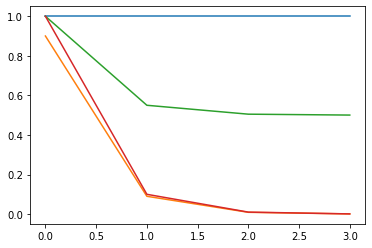

In [55]:
import matplotlib.pyplot as plt
plt.plot(range(len(V)), [tf1(_) for _ in V])
# plt.plot(range(len(V)), [tf2(_) for _ in V])
plt.plot(range(len(V)), [tf3(_) for _ in V])
# plt.plot(range(len(V)), [tf4(_) for _ in V])
plt.plot(range(len(V)), [tf5(_) for _ in V])
plt.plot(range(len(V)), [tf5(_, 0) for _ in V])
plt.show()

In [56]:
N = 10001
idf2 = lambda t:log10(N/TF[V.index(t)]) # idf4
idf3 = lambda t:log10(max(TF)/(1+TF[V.index(t)]))+1
idf4 = lambda t:log10(max(TF)/TF[V.index(t)]) # idf4
idf5 = lambda t:log10((N-TF[V.index(t)])/TF[V.index(t)])

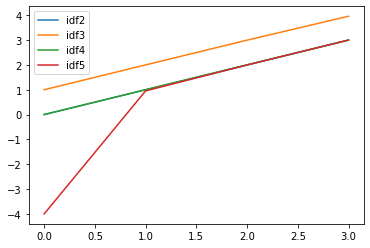

In [57]:
plt.plot(range(len(V)), [idf2(_) for _ in V], label="idf2")
# plt.plot(range(len(V)), [tf2(_) for _ in V])
plt.plot(range(len(V)), [idf3(_) for _ in V], label="idf3")
# plt.plot(range(len(V)), [tf4(_) for _ in V])
plt.plot(range(len(V)), [idf4(_) for _ in V], label="idf4")
plt.plot(range(len(V)), [idf5(_) for _ in V], label="idf5")
plt.legend()
plt.show()

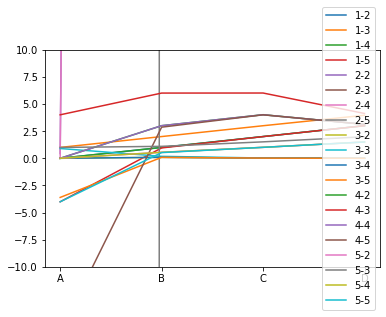

In [58]:
for i, f1 in enumerate([tf1, tf2, tf3, tf4, tf5]):
    for j, f2 in enumerate([idf2, idf3, idf4, idf5]):
        plt.plot(V, [f1(_)*f2(_) for _ in V], label='{0}-{1}'.format(i+1, j+2))
plt.legend(loc=5)
plt.ylim(-10, 10)
plt.show()


In [87]:
#-*- coding: utf-8 -*-